In [1]:
import numpy
import pandas
from src.data_objects import AllData
from src.functions import *

retrain = True
runchain = True

model_par = "input/fullDesign.txt"
ThisData = AllData
outdir = "/data/rjfgroup/rjf01/cameron.parker/tunes/full/"

Trimming points and obs ranges

In [2]:
trimRanges(ThisData)

In [3]:
badpoints = []
trimPoints(badpoints,ThisData)

Making Data pkl for selected observables

In [4]:
buildDataPkl(ThisData)
print(ThisData["datapkl"])

temp-pkls/data.pkl


Getting emulators

In [5]:
from src.emulator_BAND import EmulatorBAND

if retrain:
    buildObsPkls(ThisData)
    trainEmulators(model_par, ThisData)
else:
    readEmulators(ThisData)

[INFO][emulator_BAND] loading training data from temp-pkls/EpEm91charged-xp.pkl ...
[INFO][emulator_BAND] All training data are loaded.
[INFO][emulator_BAND] Training dataset size: 500, discarded points: 0
[INFO][emulator_BAND] Performing emulator training ...
[INFO][emulator_BAND] Train GP emulators with 500 training points ...
[INFO][emulator_BAND] loading training data from temp-pkls/EpEm91pion-xp.pkl ...
[INFO][emulator_BAND] All training data are loaded.
[INFO][emulator_BAND] Training dataset size: 500, discarded points: 0
[INFO][emulator_BAND] Performing emulator training ...
[INFO][emulator_BAND] Train GP emulators with 500 training points ...
[INFO][emulator_BAND] loading training data from temp-pkls/EpEm91kaon-xp.pkl ...
[INFO][emulator_BAND] All training data are loaded.
[INFO][emulator_BAND] Training dataset size: 500, discarded points: 0
[INFO][emulator_BAND] Performing emulator training ...
[INFO][emulator_BAND] Train GP emulators with 500 training points ...
[INFO][emulat

Running Chain

In [6]:
from src.mcmc import Chain
import os

mymcmc = Chain(expdata_path=ThisData["datapkl"], model_parafile=model_par)
mymcmc.loadEmulator(getEmuPathList(ThisData))

[INFO][mcmc] Initializing MCMC ...
[INFO][mcmc] Final Markov Chain results will be saved in mcmc/chain.pkl
[INFO][mcmc] Loading the model parameters space from input/fullDesign.txt ...
[INFO][mcmc] Run MCMC with emcee...
[INFO][mcmc] Loading the experiment data from temp-pkls/data.pkl ...
[INFO][mcmc] Experimental dataset size: 391
[INFO][mcmc] Number of Emulators: 12


In [7]:
os.environ["OMP_NUM_THREADS"] = "1"
# may have to: export RDMAV_FORK_SAFE=1 before running the code

n_effective=2000
n_active=1000
n_prior=4000
sample="tpcn"
n_max_steps=100
random_state=42

n_total = 25000
n_evidence = 0

pool = 12

if runchain:
    sampler = mymcmc.run_pocoMC(n_effective=n_effective, n_active=n_active,
                            n_prior=n_prior, sample=sample,
                            n_max_steps=n_max_steps, random_state=random_state,
                            n_total=n_total, n_evidence=n_evidence, pool=pool)

[INFO][mcmc] Generate the prior class for pocoMC ...
[INFO][mcmc] Starting pocoMC ...


Iter: 53it [5:08:36, 349.36s/it, beta=1, calls=353000, ESS=24881, logZ=1.81e+3, logP=1.84e+3, acc=0.805, steps=11, eff=1]  

[INFO][mcmc] Generate the posterior samples ...


[INFO][mcmc] Generate the evidence ...
Log evidence:  1808.7146832955007
Log evidence error:  None
[INFO][mcmc] Writing pocoMC chains to file...


Corner Plot

[WARNING][core] Too few points to create valid contours


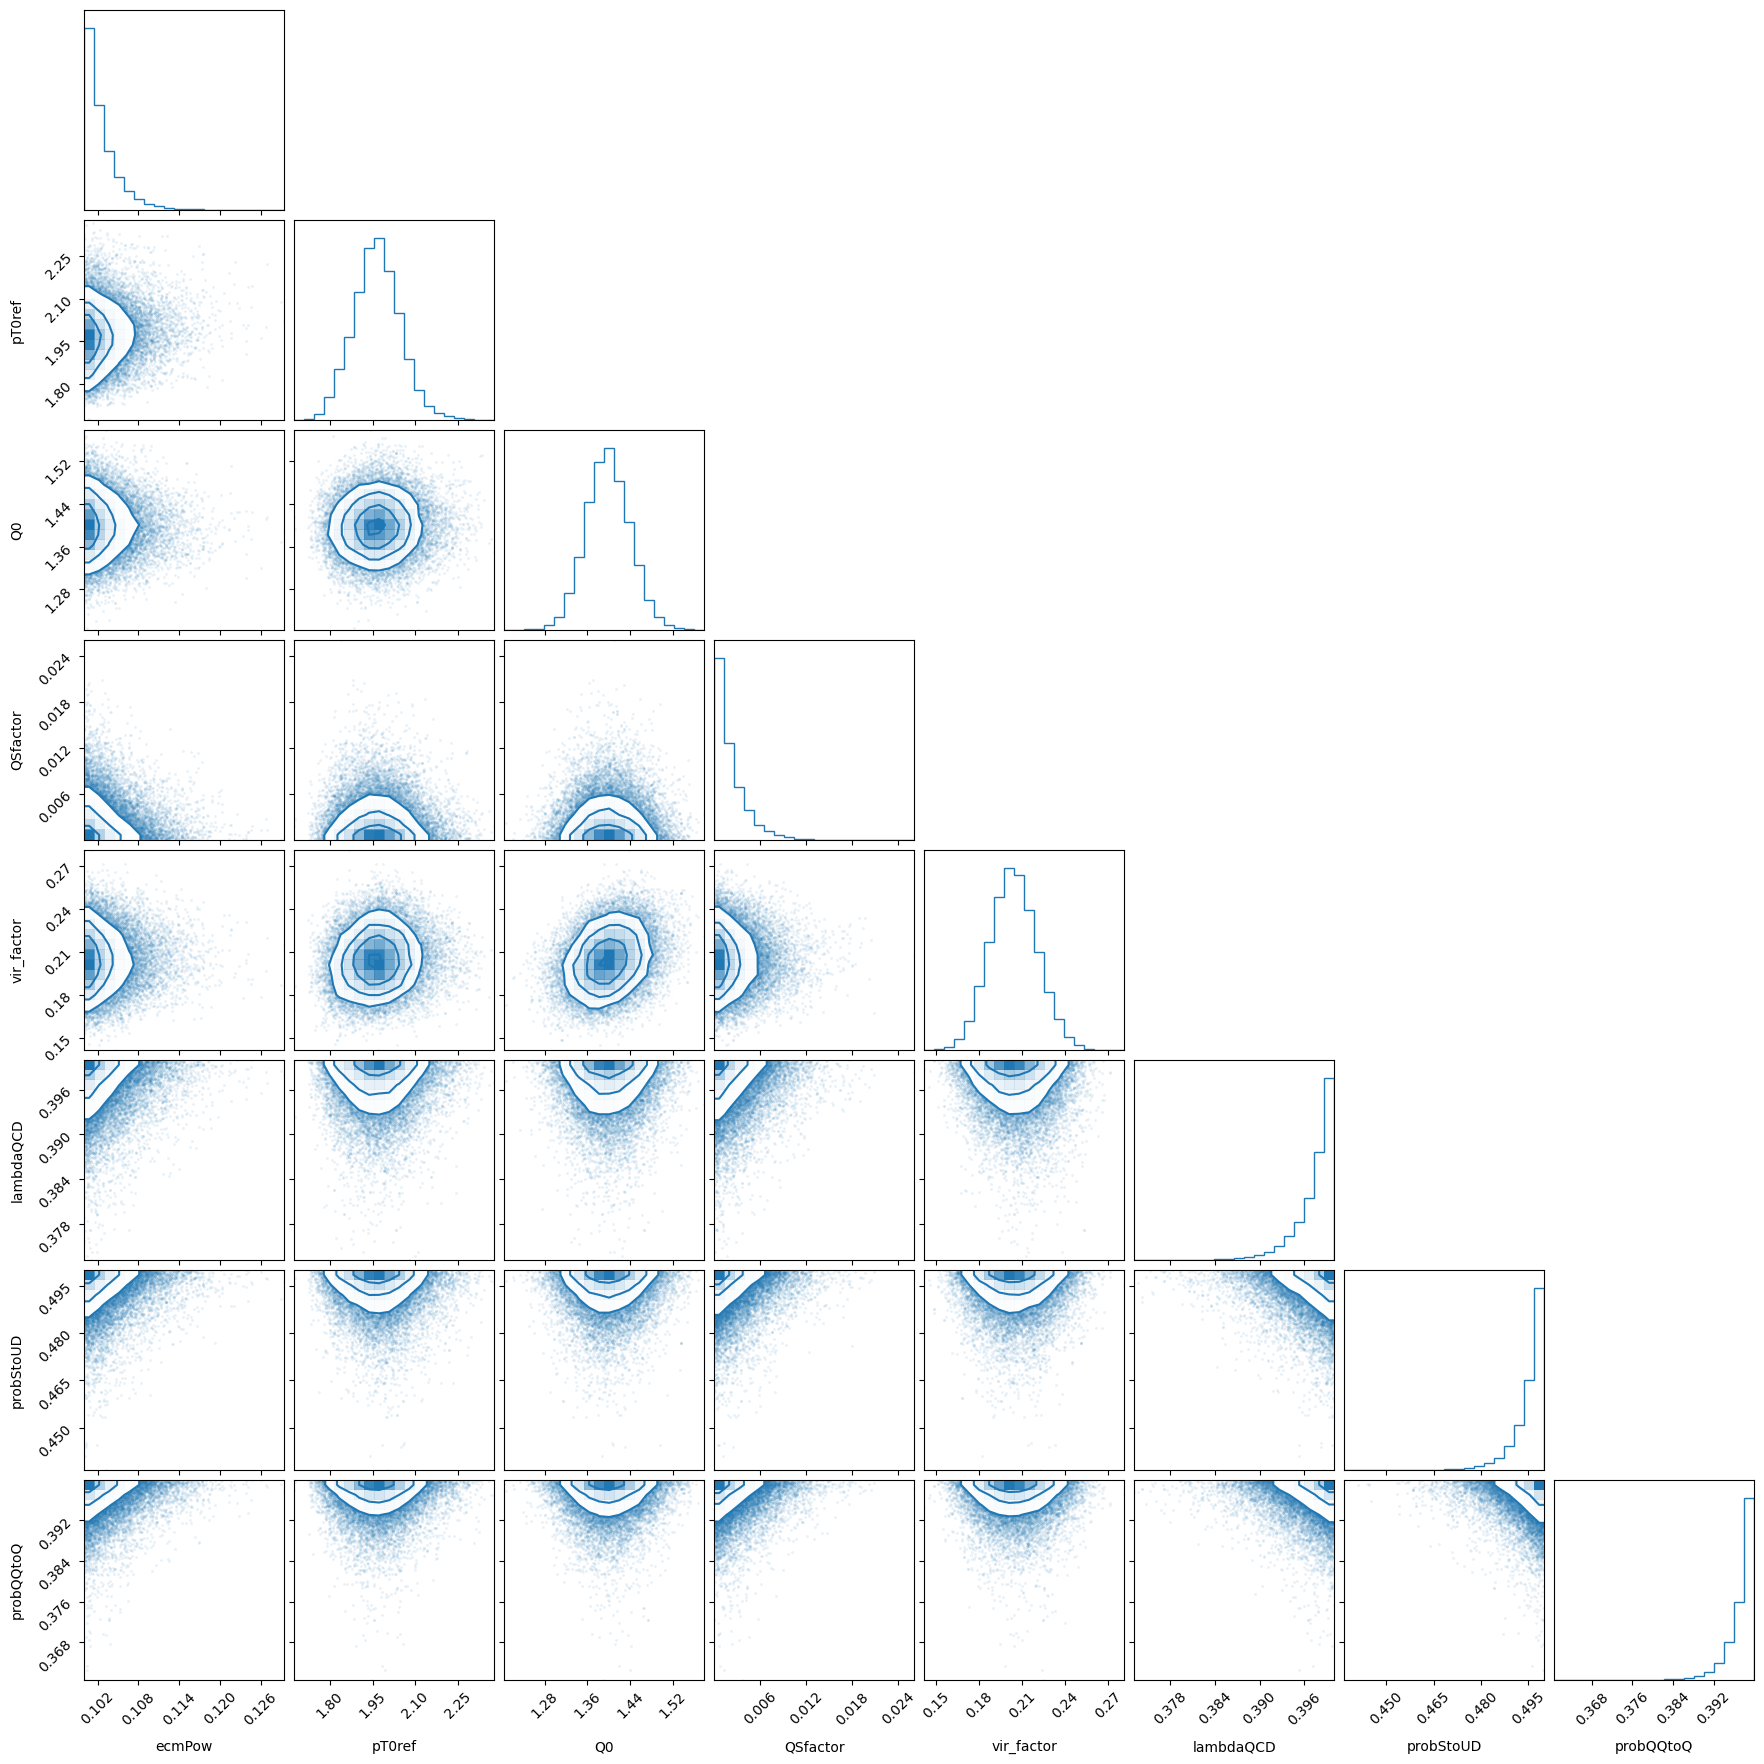

In [8]:
import pickle
import corner
import matplotlib.pyplot as plt
import numpy as np
        
with open('mcmc/chain.pkl', 'rb') as pf:
        data = pickle.load(pf)

labels = mymcmc.label

fig = corner.corner(data['chain'], weights=data['weights'], labels=labels, color="C0")
plt.show()

[WARNING][core] Too few points to create valid contours


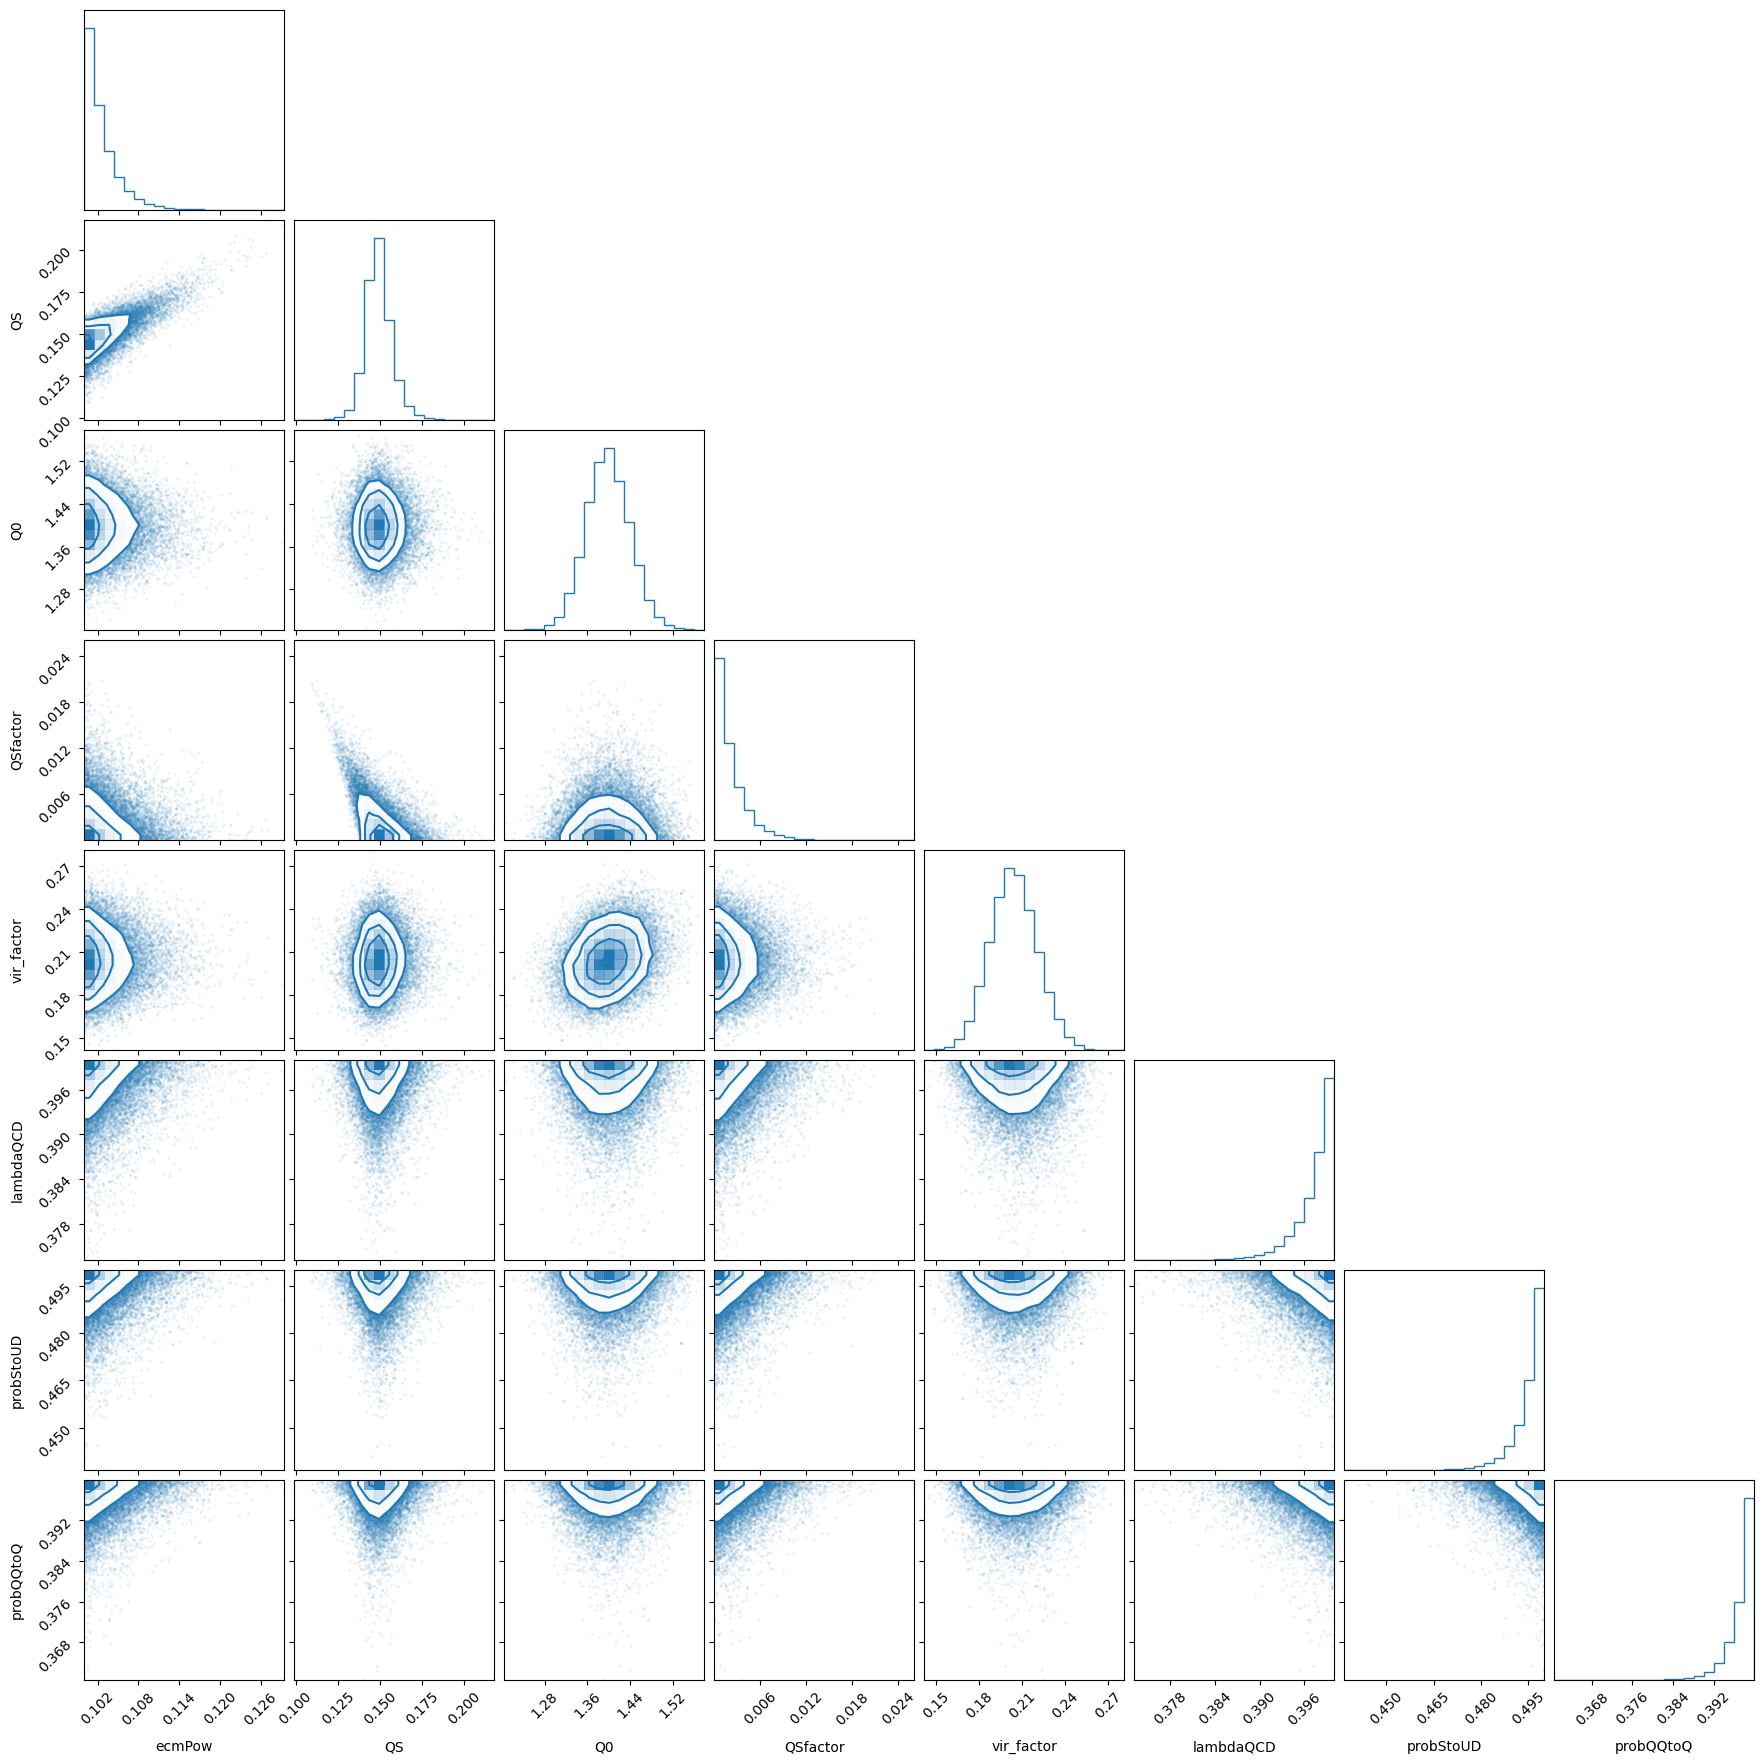

ecmPow: 0.102-0.002+0.007
QS: 0.149-0.012+0.015
Q0: 1.398-0.068+0.072
QSfactor: 0.002-0.001+0.005
vir_factor: 0.204-0.027+0.029
lambdaQCD: 0.398-0.007+0.002
probStoUD: 0.497-0.013+0.003
probQQtoQ: 0.398-0.007+0.002


In [9]:
TransformedSamples = np.copy(data['chain'])
TransformedSamples[:,0] = data['chain'][:,0]
TransformedSamples[:,1] = (2*data['chain'][:,3]+0.05) + (data['chain'][:,0]-(2*data['chain'][:,3]+0.05))*data['chain'][:,1]
TransformedSamples[:,2] = data['chain'][:,2]
TransformedSamples[:,3] = data['chain'][:,3]
TransformedSamples[:,4] = data['chain'][:,4]
TransformedSamples[:,5] = data['chain'][:,5]

labels[1] = "QS"
fig = corner.corner(TransformedSamples, weights=data['weights'], labels=labels, color="C0")
plt.show()

bestParams = extract_parameters(TransformedSamples, labels, "/data/rjfgroup/rjf01/cameron.parker/tunes/epem/")

Priors

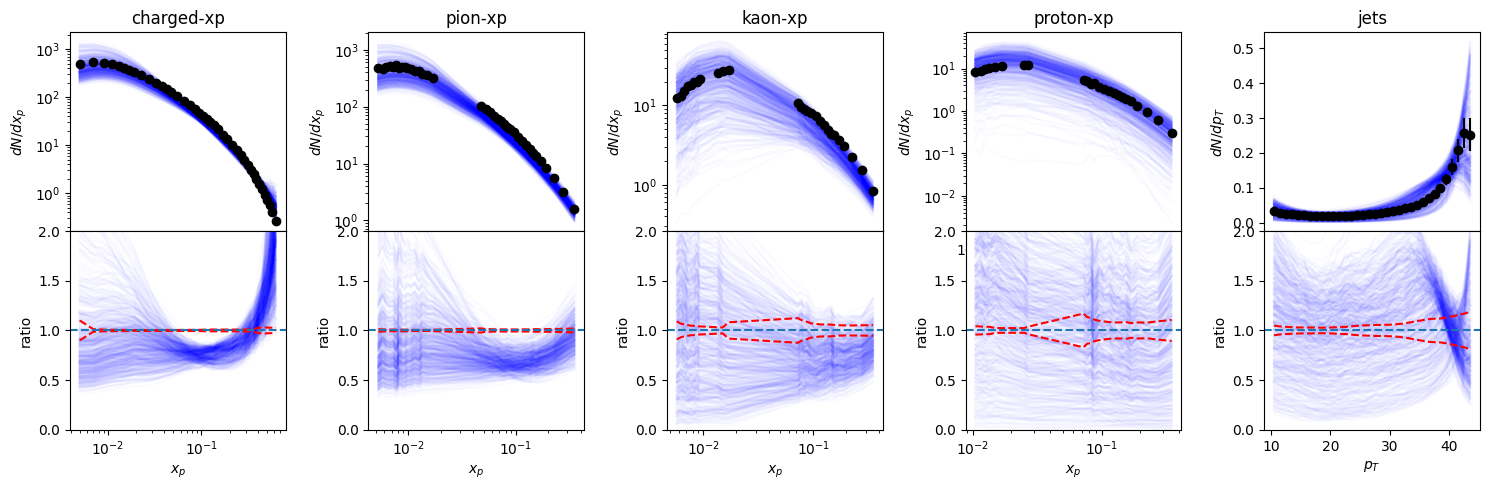

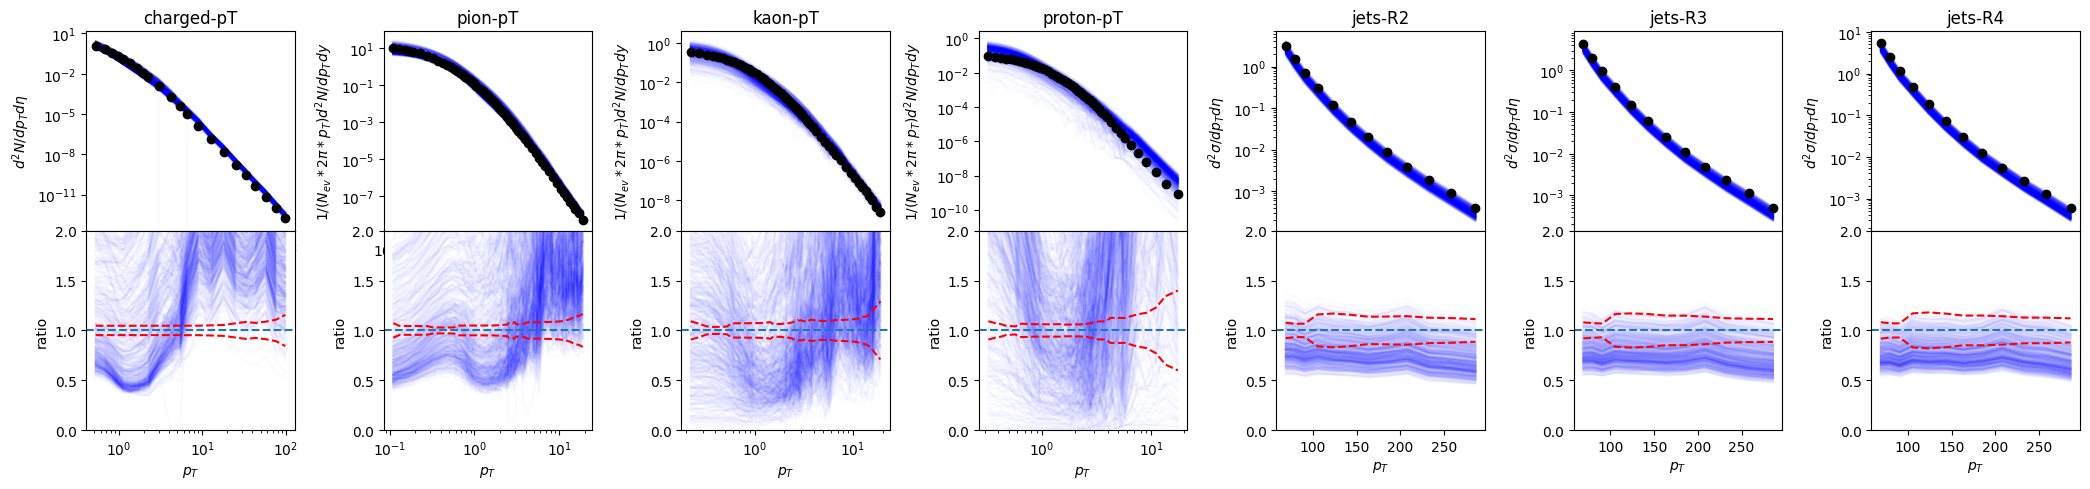

In [10]:
makeplot(ThisData, "Priors", "/data/rjfgroup/rjf01/cameron.parker/tunes/epem/")

Posteriors

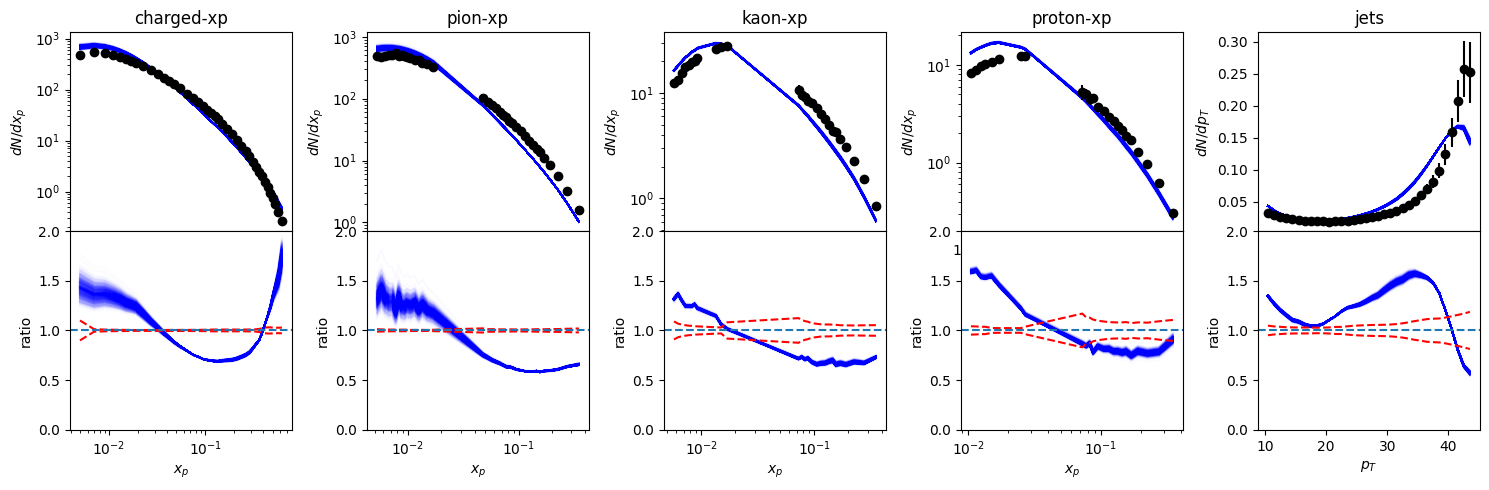

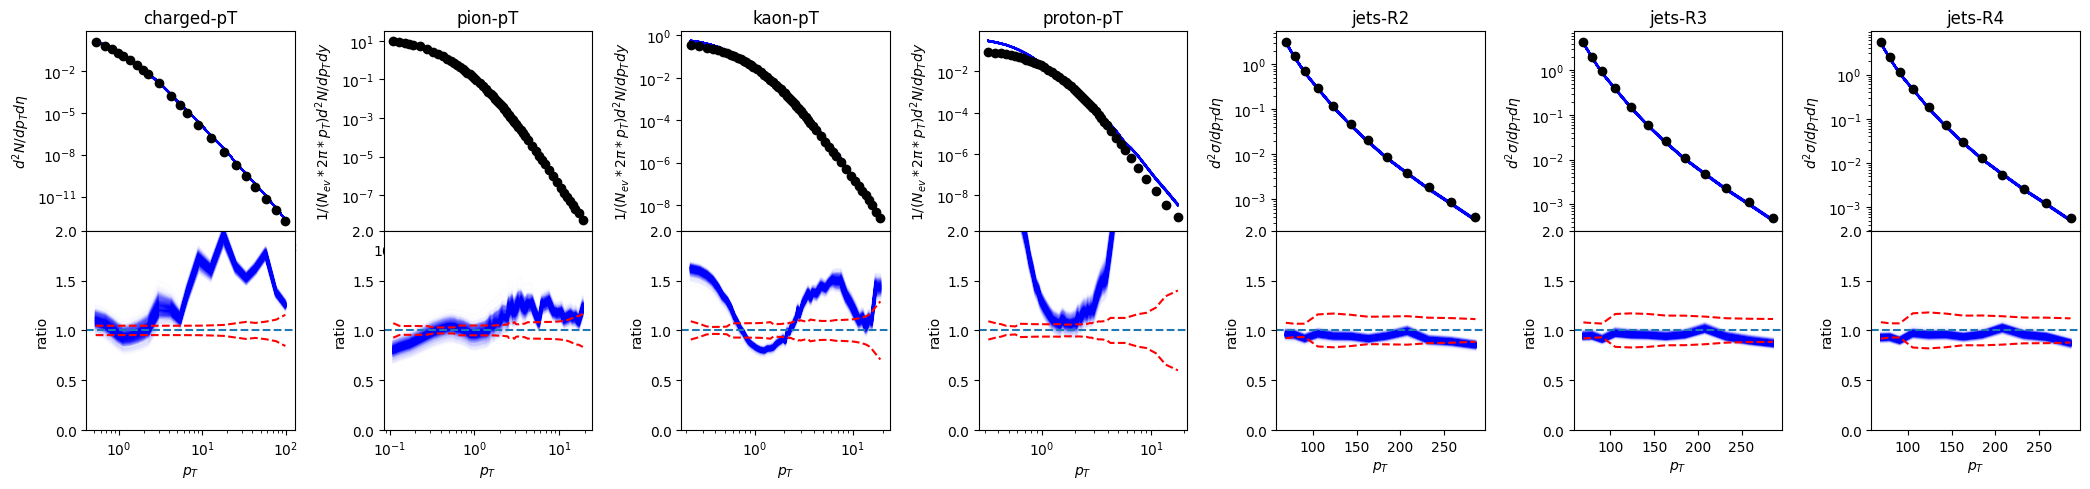

In [11]:
makeplot(ThisData, "Posteriors", "/data/rjfgroup/rjf01/cameron.parker/tunes/epem/", samples=data["chain"])